<a href="https://colab.research.google.com/github/SamarSaeed1146/Internet_Chatbot/blob/main/internet_chatbot_with_nodes_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install -U langchain_google_genai langgraph langchain_core langchain tavily-python langchain_community

In [2]:
import os
from google.colab import userdata

os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'internet_search'
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=gemini_api_key,
    max_retries=2,
    temperature=0.5,
)

llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-7fbab1e4-30e7-4eb6-9d58-607aeeefe84c-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("what is langgraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/',
  'content': 'Overview¶. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from DAG-based solutions.'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner.'}]

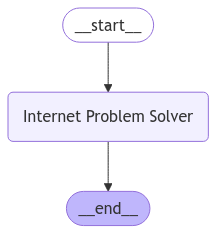

In [5]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from typing_extensions import Annotated, TypedDict

def internet_problem_solver(user_input: str):
    if "internet" not in user_input.lower():
        return "I can only assist with internet-related problems. Please ask about issues such as slow speeds, connection drops, or Wi-Fi setups."

    responses = []
    try:
        tool_response = tool.invoke(user_input)

        if tool_response:
            responses.append(f"{tool_response}")
    except Exception as e:
        print(f"Error invoking TavilySearchResults: {str(e)}")
        responses.append(f"Error with TavilySearchResults: {str(e)}")

    try:
        llm_response = llm.invoke(user_input)

        if llm_response:
            responses.append(f"{llm_response}")
    except Exception as e:
        print(f"Error invoking LLM: {str(e)}")
        responses.append(f"Error with LLM: {str(e)}")

    if responses:
        return "\n\n".join(responses)
    else:
        return "No meaningful response from tools or LLM."

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
graph_builder.add_node("Internet Problem Solver", internet_problem_solver)
graph_builder.add_edge(START, "Internet Problem Solver")
graph_builder.add_edge("Internet Problem Solver", END)
graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass
